# Rescorla-Wagner Reinforcement Learning
By Shawn Rhoads (NSCI 526)

Adapted from [O'Reilly & den Ouden, 2015](http://www.hannekedenouden.ruhosting.nl/RLtutorial/html/RL_topPage.html) & [cldssty, 2018](https://github.com/cldssty/Gambling-Game/blob/master/data%20analysis/%20Gambling%20Game%20Code.ipynb)


In [1]:
import os
import scipy.io as sio
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pylab import cm,imshow,colorbar,axis,show

In [2]:
datapath = glob(os.path.join('data/*.mat'))
data = [sio.loadmat(file, squeeze_me=True, struct_as_record=False) for file in datapath]

In [3]:
choices = {}
choices_blue = {}
rewards = {}
prob_blue = {}
trials = range(1,136)

for index, sub_data in enumerate(data):
    choices[index] = sub_data['data'].choice - 1
    choices_blue[index] = [i if i==1 else 0 for i in sub_data['data'].choice] #change 2s to 0s
    rewards[index] = sub_data['data'].prep.feedback
    prob_blue[index] = sub_data['data'].prep.feedbackprob # probability of reward of one of the machines

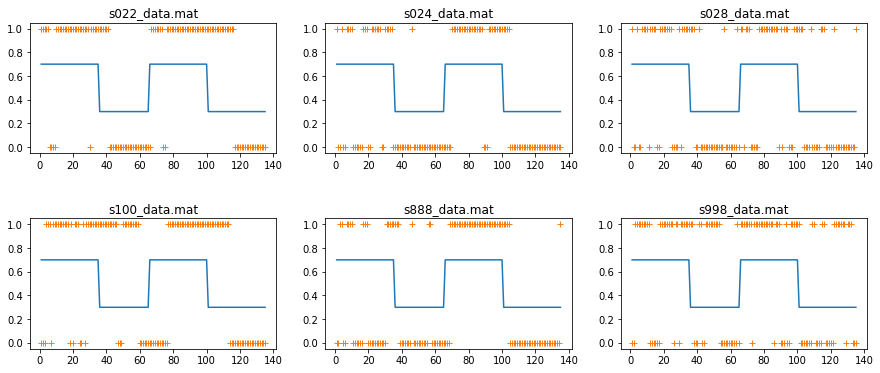

In [4]:
# plot choices and feedback probabilities against trials for each subject
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5)

for ax, (index, feature) in zip(axs.flatten(), enumerate(datapath)):
    ax.plot(trials, prob_blue[index], '-', trials, choices_blue[index], '+')
    ax.set(title=os.path.basename(feature)[-13:])

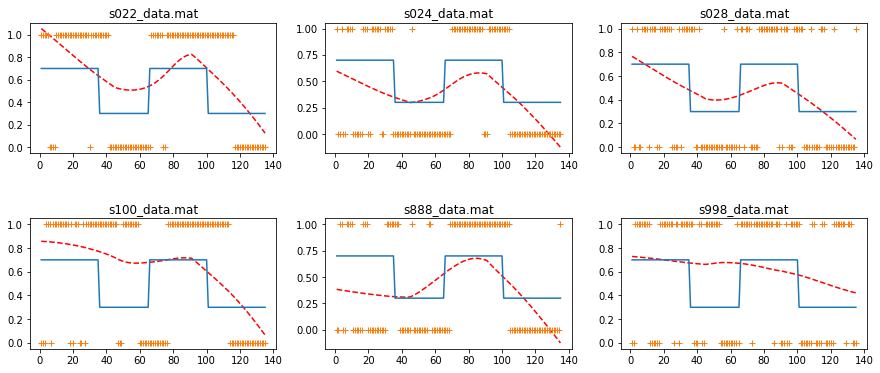

In [5]:
# add smoothed choice using lowess
lowess = sm.nonparametric.lowess

fig, axs = plt.subplots(2, 3, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5)

for ax, (index, feature) in zip(axs.flatten(), enumerate(datapath)):
    smoothedchoice = lowess(choices_blue[index], trials)
    ax.plot(trials, smoothedchoice[:, 1], 'r--', trials, prob_blue[index], '-', trials, choices_blue[index], '+')
    ax.set(title=os.path.basename(feature)[-13:])

plt.show()

### Reinforcement Learning

**I. Definitions**

1. For each trial, we associate a value between 0 and 1 with each machine called the **stimulus value**. Let $v_{t ,s}$ be the stimulus value of machine $s$ at trial $t$, then $v_{t, 1-s} = 1-v_{t, s}$.
2. $r_{t, s}$ is the reward/feedback from machine s at trial $i$. 
3. $\alpha$ is a parameter between 0 and 1. We will explore the effects of varying it later, and then find a possible interpretation for it. 
4. $cp_{t, s}$ is the probability of choosing machine s at trial $t$. 
5. $\beta$ is a non-negative parameter. Again we will explore this further later.

**II. Theory**

The **Rescorla-Wagner Equation** is a way of updating stimulus values of each machine using the reward from the machine chosen in the most recent trial and the parameter $\alpha$. 
    $$v_{t+1, s} = v_{t, s} + \alpha(r_{t, s} - v_{t, s})$$
<br>
The new stimulus values are used to generate choice probabilities for the upcoming trial using the **Softmax Equation**:
    $$cp_{t+1, s} = \frac{exp(\beta v_{t+1, s})}{\sum_{s \in \Omega_{s}}\beta v_{t+1, s}}$$    

where $\Omega_{s}$ is the set of values $s$ takes. 

**III. Simulation steps:**

1. take stimulus value for each machine 
2. use Softmax to generate choice probabilities 
3. toss a biased coin to generate a choice from the choice probabilities 
4. get reward 
5. plug into Rescorla Wagner to get new stimuli values 
6. repeat

In [6]:
#let's simulate some possible choices based on the following parameter values:

alpha = 0.25
beta = 4

In [7]:
## init v, choice probabilities, and choices

# matrix of stimuli values 
v = np.zeros((135, 2), dtype = float)

# matrix of choice probabilities 
cp = np.zeros((135, 2), dtype = float)

# matrix of choices 
c = np.zeros(135, dtype=int)

## set initial values 

# stim[t, :] = stimuli from trial i
v[0, :] = [0, 0]

# cp[t, :] = probabilities of choosing each machine at trial t + 1
cp[0, :] = [.5, .5] 

# log likelihood for data fitting 
loglik = 0

# log likelihood for optimal performance
loglikopt = 0 

## for loop for learning
for t in range(0, 134): 
    # generate random number between 0 and 1 
    h = np.random.random_sample(1)
    if h <= cp[t, 0]: 
        c[t] = 0
    else: 
        c[t] = 1
    
    # substitute into RW equation to get new stimulus for chosen machine 
    s = c[t]
     
    # RW equation: 
    v[t+1, s] = v[t, s] + alpha*(rewards[0][t, s] - v[t, s])
    v[t+1, 1-s] = 1 - v[t+1, s]
    
    # then substitute two stimuli into softmax equation to get choice probability for machine s 
    # Softmax equation:
    cp[t+1, s] = (np.exp(beta*v[t+1,s]))/(np.exp(beta*v[t+1,0]) + np.exp(beta*v[t+1,1]))
    cp[t+1, 1-s] = 1 - cp[t+1, s]
    
    # compute log likelihoods for optimal performance 
    if rewards[0][t, 1] == 1:
        loglikopt = loglikopt + np.log(cp[t, 1])
    else:
        loglikopt = loglikopt + np.log(cp[t, 0])
    
    if (t % 10 == 0) or (t == 133): # print for every tenth
        print("-----------------------------------------------")
        print(f"stimulus chosen: s=c(t): {s}")
        print()
        
        print(f"value of stimulus at t: v(t, s): {v[t, s]}")
        print()
        
        print(f"probability of choice at t: cp(t, s): {cp[t, s]}")
        print()
        
        print(f"prediction error [ actual ({rewards[0][t, s]}) - predicted ({v[t, s]}) ] = {rewards[0][t, s] - v[t, s]}")
        print()
        
        print(f"value of stimulus at t+1: v(t+1, s): {v[t+1, s]}")
        print()

        print(f"probability of choice at t+1: cp(t+1, s): {cp[t+1, s]}")
        print()

        print(f"loglikelihood: {loglikopt}")
        print()

-----------------------------------------------
stimulus chosen: s=c(t): 1

value of stimulus at t: v(t, s): 0.0

probability of choice at t: cp(t, s): 0.5

prediction error [ actual (0) - predicted (0.0) ] = 0.0

value of stimulus at t+1: v(t+1, s): 0.0

probability of choice at t+1: cp(t+1, s): 0.01798620996209156

loglikelihood: -0.6931471805599453

-----------------------------------------------
stimulus chosen: s=c(t): 0

value of stimulus at t: v(t, s): 0.7837066650390625

probability of choice at t: cp(t, s): 0.9063323608781159

prediction error [ actual (0) - predicted (0.7837066650390625) ] = -0.7837066650390625

value of stimulus at t+1: v(t+1, s): 0.5877799987792969

probability of choice at t+1: cp(t+1, s): 0.6686842196005055

loglikelihood: -13.551524862749307

-----------------------------------------------
stimulus chosen: s=c(t): 0

value of stimulus at t: v(t, s): 0.6784602116240421

probability of choice at t: cp(t, s): 0.8065398396582049

prediction error [ actual (1

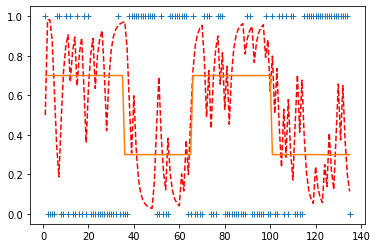

In [8]:
plt.plot(trials, c, '+', trials, cp[:, 0], 'r--', trials, prob_blue[0], '-')
plt.show()

In [9]:
def rw_learning_sim(index, alpha, beta):
    ## init v, choice probabilities, and choices

    # matrix of stimuli values 
    v = np.zeros((135, 2), dtype = float)

    # matrix of choice probabilities 
    cp = np.zeros((135, 2), dtype = float)

    # matrix of choices 
    c = np.zeros(135, dtype=int)

    ## set initial values 

    # stim[t, :] = stimuli from trial i
    v[0, :] = [0, 0]

    # cp[t, :] = probabilities of choosing each machine at trial t + 1
    cp[0, :] = [.5, .5] 

    # log likelihood for data fitting 
    loglik = 0

    # log likelihood for optimal performance
    loglikopt = 0 

    ## for loop for learning    
    for t in range(0, 134): 
        # generate random number between 0 and 1 
        h = np.random.random_sample(1)
        if h <= cp[t, 0]: 
            c[t] = 0
        else: 
            c[t] = 1

        # substitute into RW equation to get new stimulus for chosen machine 
        s = c[t]
        
        # RW equation: 
        v[t+1, s] = v[t, s] + alpha*(rewards[index][t, s] - v[t, s])
        v[t+1, 1-s] = 1 - v[t+1, s]

        # then substitute two stimuli into softmax equation to get choice probability for machine s 
        # Softmax equation:
        cp[t+1, s] = (np.exp(beta*v[t+1,s]))/(np.exp(beta*v[t+1,0]) + np.exp(beta*v[t+1,1]))
        cp[t+1, 1-s] = 1 - cp[t+1, s]

        # compute log likelihoods for optimal performance 
        if rewards[index][t, 1] == 1:
            loglikopt = loglikopt + np.log(cp[t, 1])
        else:
            loglikopt = loglikopt + np.log(cp[t, 0])
    
    return c, cp, loglikopt

### What happens if we change $\alpha$ ?

Recall: 
$v_{t+1, s} = v_{t, s} + \alpha(r_{t, s} - v_{t, s})$

In [10]:
c0, cp0, loglikopt0 = rw_learning_sim(0, .1, 3)
c1, cp1, loglikopt1 = rw_learning_sim(0, .5, 3)
c2, cp2, loglikopt2 = rw_learning_sim(0, .9, 3)

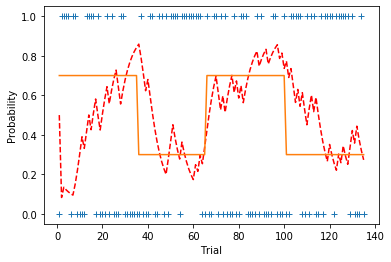

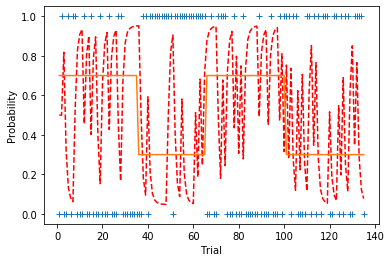

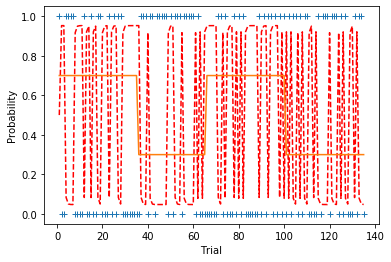

In [11]:
# plot 
plt.plot(trials, c0, '+', trials, cp0[:, 0], 'r--', trials, prob_blue[0], '-')
plt.ylabel("Probability")
plt.xlabel("Trial")
plt.show()

plt.plot(trials, c1, '+', trials, cp1[:, 0], 'r--', trials, prob_blue[0], '-')
plt.ylabel("Probability")
plt.xlabel("Trial")
plt.show()

plt.plot(trials, c2, '+', trials, cp2[:, 0], 'r--', trials, prob_blue[0], '-')
plt.ylabel("Probability")
plt.xlabel("Trial")
plt.show()

As $\alpha$ increases, the difference in choice probabilities of trial $t$ and trial $t+1$ increases for all $t > 1$. So it can be interpreted as the sensitivity to reward and punishment. 

### What happens if we change $\beta$ ?

Recall, softmax rule: $cp_{t+1, s} = \frac{exp(\beta*v_{t+1, s})}{\sum_{s \in \Omega_{s}}exp(\beta*v_{t+1, s})}$
where $\Omega_{s}$ is the set of values $s$ takes. 

If $\beta$ is negative, then for any given pair of stimuli $v$ and $1-v$, the smaller stimuli yields a higher choice probability, which doesn't make sense! If $\beta<0$, that would mean the subject would be more likely to pick the stimulus that has the lowest value...  

**So $\beta$ is a non-negative real number.**

Notice that if $\beta = 0$, then choice probability = 0.5.  

If take limit $\beta \rightarrow \infty$, then choice probability converges to 0. 

One way of finding out a possible interpretation of $\beta$ is to do some plots. There are many plots you can do but a particularly useful thing to do is to plot the choice probabilities for a machine over a range of differences between the stimulus values for several values of $\beta$. 

I say several values of $\beta$ because we cannot include all possible values of $\beta$ in the plot. There are many different ways of constraining the values of this parameter. The simplest is to set an arbitrary hard bound.

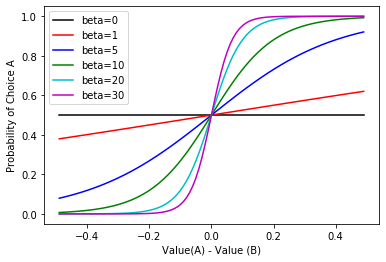

In [12]:
# Assume there are 2 stimuli A and B, where the value of B is always [1-value A]. 
# Subject should choose A most of the time when v_A > v_B, but not always

# This is where the term 'softmax' comes from: the subject picks the 
#     stimulus with the maximum value most of the time, so it's a 'soft' maximising function

# For simplicity we pick a fixed v_B
v_B = 0.5 # value of B (fixed)
v_A = np.arange(0.01, 1, 0.01) # value of A from .01 to 1 (99 stimulus values)

# assume 99 stimulus pairs
diff = np.zeros(99)
for j in range(0, 99):
    diff[j] = v_A[j] - v_B # difference in Value(A) - Value (B)

# choice probabilities
def choiceprobsdiff(bv):
    cpd = np.zeros(99)
    for i in range(0, 99):
        cpd[i] = np.exp(bv*v_A[i])/(np.exp(bv*v_A[i]) + np.exp(bv*v_B))
    return cpd 

# plot for several values of beta 
plt.plot(diff, choiceprobsdiff(0), 'black', label="beta=0")
plt.plot(diff, choiceprobsdiff(1), 'r-', label="beta=1")
plt.plot(diff, choiceprobsdiff(5), 'b-', label="beta=5") 
plt.plot(diff, choiceprobsdiff(10), 'g-', label="beta=10") 
plt.plot(diff, choiceprobsdiff(20), 'c-', label="beta=20") 
plt.plot(diff, choiceprobsdiff(30), 'm-', label="beta=30") 
plt.legend(loc="upper left")
plt.ylabel("Probability of Choice A")
plt.xlabel("Value(A) - Value (B)")
plt.show()

Can we set the values of $\alpha$ and $\beta$ so that we get the optimal performance of the model in the gambling game with this particular sequence of feedback probabilities? There are many ways to achieve this. Here, we use Grid Search.

We run model over all possible parameter settings to find out which one gives the maximal probability of feedback probabilities = choice probabilities of model i.e. we find the maximum likelihood estimator $\alpha$ and $\beta$.

This is the parameter setting that gives the best performance using this model. 

In [13]:
# Grid Search for model that gives optimal performance 
# instead of adding up the log likelihoods of getting the choices in the given data, 
# we add up log likelihoods of choosing the right machines based on data.prep.feedback 

def Likelihoodopt(alpha, beta): 
    c, cp, loglikopt = rw_learning_sim(0, alpha, beta)
    likopt = np.exp(loglikopt)
    return likopt

parama = np.arange(0, 1, 0.05)
paramb = np.arange(0, 15, 0.6)

Likopt = []

for alpha in parama:
    for beta in paramb:
        Likopt = np.append(Likopt, Likelihoodopt(alpha, beta))

In [14]:
len(paramb)

25

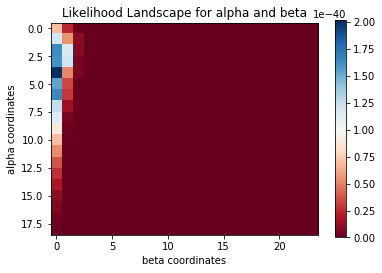

In [15]:
## plot likelihoods

# could just plot this but would include all cases in which 
#      alpha = 0 and beta = 0, which don't make sense
Likopt = Likopt.reshape((20, 25))

# here we delete nonsensical cases
Likoptnonzero = []
for i in range(1, 20):
    for j in range(1, 25):
        Likoptnonzero = np.append(Likoptnonzero, Likopt[i ,j])

Likoptnonzero = Likoptnonzero.reshape(19, 24)
im = imshow(Likoptnonzero, cmap=cm.RdBu)
colorbar(im)
plt.ylabel("alpha coordinates")
plt.xlabel("beta coordinates")
plt.title("Likelihood Landscape for alpha and beta")
show() 

This plot is a 2-dimensional heatmap that indicates the probability of the data given the model, with cooler colours meaning higher likelihood 
- Along the x-axis, we are varying β whilst keeping α constant
- Along the y-axis, we are varying α whilst keeping β constant
- If we had had 3 parameters in our model, this would become a 3D plot (and much harder to visualise!).

In [16]:
# find maxima
mleopt = np.zeros(2)
for a in list(range(0, len(parama))): 
        for b in list(range(0, len(paramb))):
            if Likopt[a, b] == np.amax(Likopt):
                mleopt[0] = a*0.05
                mleopt[1] = b*0.6  

print(f"coords on grid: {[mleopt[0]/0.05, mleopt[1]/0.6]}")                
print(f"[alpha, beta] = {mleopt}")

coords on grid: [5.0, 1.0]
[alpha, beta] = [0.25 0.6 ]


Let $(i, j)$ be integral coordinates on the grid. Then the likelihood of $(i, j)$ is the likelihood of the $i$-th value of alpha and the $j$-th value of beta.  

**Why does the MLE change everytime?**

Because everytime the model runs, the first choice generated only has a 0.5 probability of being the same as the one before. Then the stimulus for the first trial might change, and so would the choice probability, and so on and so forth. Since loglik is the sum of all logs of choice probabilities, it would also be different from before.

-  The likelihood values for different values of α and β do not vary independently. Rather, there seems to be a positive correlation between them. Such a correlation signals that your parameters are to some degree non-identifiable, and that parameter values trade off against each other. 
- Looking for structure in your likelihood 'landscapes' of simulated and refitted data is a good way to check whether you have a nicely behaved model with sufficiently independent/identifiable parameters. 


## Data Fitting

We now fit the model to the data. The rough algorithm is as follows: 
1. start with initial stimulus value for each machine 
2. compute choice probability for each machine 
3. get player choice and corresponding outcome from dataset 
4. use above to update stimulus value $v$ of chosen machine 
5. stimulus value of other machine is $1 - v$ 
6. repeat

In [17]:
def Fit(alpha, beta, trials, choices, rewards):
    
    # initialize values (all zeros)
    v = np.zeros((len(trials), 2))
    v[0, :] = [0, 0]
    
    # init choice probabilities
    cp = np.zeros((len(trials), 2)) 
    cp[0, :] = 0.5*np.ones((1, 2)) # start with .5 chance at first trial
    
    # init loglik, we want to minimize this
    loglik = 0
    
    # set c, r to choices, rewards for the subject
    c = choices
    r = rewards
    
    # loop along trials
    for t in range(0, 134):
        
        # softmax rule
        cp[t, 0] = np.exp(beta*v[t, 0])/(np.exp(beta*v[t, 0]) + np.exp(beta*v[t, 1]))
        cp[t, 1] = 1 - cp[t, 0]
        
        # choice
        s = c[t]
        
        # update value of stimulus
        v[t+1, s] = v[t, s] + alpha*(r[t, s] - v[t, s]) 
        v[t+1, 1-s] = 1 - v[t, s]
        
        # compute loglikelihood
        if c[t] == 0:
            loglik = loglik + np.log(cp[t, 0])
        else:
            loglik = loglik + np.log(cp[t, 1])
    
    return loglik, v, cp

# convert loglikelihood 
def Likelihood(alpha, beta, trials, choices, rewards):
    
    [loglik, v, cp] = Fit(alpha, beta, trials, choices, rewards)
    lik = np.exp(loglik)
    
    return lik

In [18]:
# Run MLE to estimate alpha and beta
alpha = np.arange(0, 1, 0.05)
beta = np.arange(0, 15, 0.6)

Lik = {}

for index, subj in enumerate(data):
    print(f"running subject: {index}")
    Lik[index] = []
    
    for alpha in parama:
        for beta in paramb:
            Lik[index] = np.append(Lik[index], Likelihood(alpha, beta, trials, choices[index], rewards[index]))

running subject: 0
running subject: 1
running subject: 2
running subject: 3
running subject: 4
running subject: 5


Now we plot the likelihood landscape and find the maximum likelihood estimators of alpha and beta for this particular dataset.

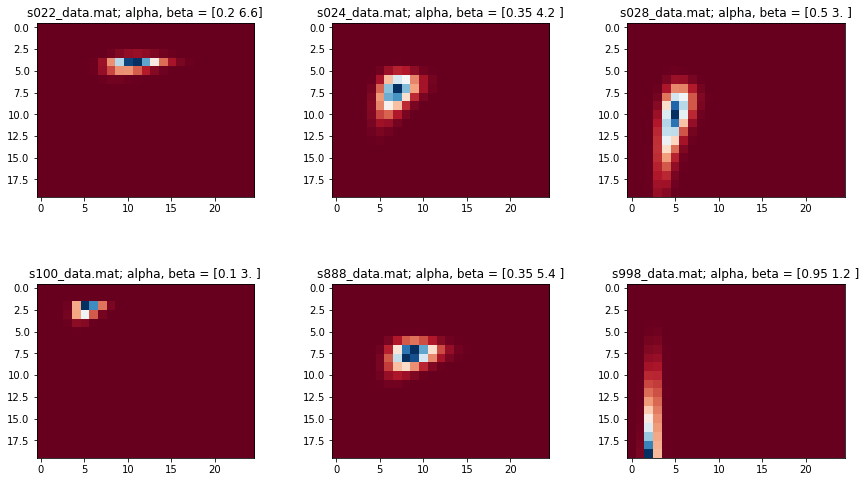

In [19]:
## plot likelihoods for each subject

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)

for ax, (index, feature) in zip(axs.flatten(), enumerate(datapath)):
    
    likelihood = Lik[index].reshape((20,25))    
    Liknonzero = []
    
    mle = np.zeros(2)
    coords = np.zeros(2)
    for i in range(1, 20):
        for j in range(1, 25):
            
            # get rid of wackadoodle cases (e.g., alpha=0, beta=0)
            Liknonzero = np.append(Liknonzero, likelihood[i ,j])
    
            # if the coords of a likelihood is (i, j),
            # then the likelihood is that of the ith value of alpha 
            # and the jth value of beta
            if likelihood[i, j] == np.amax(likelihood):
                mle[0] = i*0.05
                mle[1] = j*0.6
                coords[0] = i
                coords[1] = j
            
    Liknonzero = Liknonzero.reshape(19, 24)
    ax.imshow(likelihood, cmap=cm.RdBu)
    ax.set(title=f"{os.path.basename(feature)[-13:]}; alpha, beta = {mle}")
    
# below the alpha value will correspond to the ith value of alpha and the jth value of beta

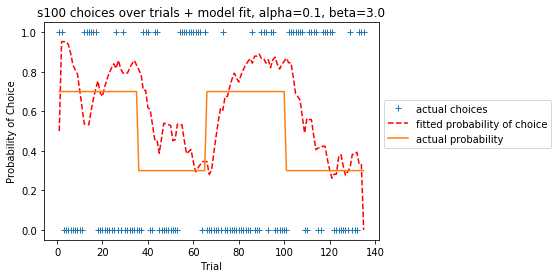

In [20]:
# let's take one person and look at how well our model performs:
alpha_s100 = 0.1
beta_s100 = 3.0

[loglik_100, v_100, cp_100] = Fit(alpha_s100, beta_s100, trials, choices[5], rewards[5])

# plot 
plt.plot(trials, choices[5], '+', label="actual choices")
plt.plot(trials, cp_100[:, 0], 'r--', label="fitted probability of choice")
plt.plot(trials, prob_blue[0], '-', label="actual probability")
plt.ylabel("Probability of Choice")
plt.xlabel("Trial")
plt.title(f"s100 choices over trials + model fit, alpha={alpha_s100}, beta={beta_s100}")
plt.legend(bbox_to_anchor=(1, .4), loc='lower left', ncol=1)
plt.show()

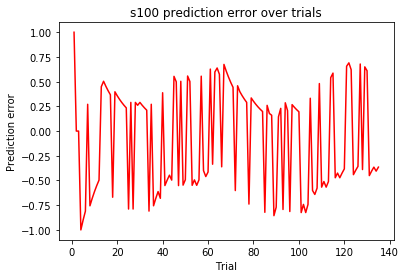

In [21]:
# we can also plot prediction errors over trials:
PE = rewards[5][:, 0] - v_100[:, 0]
plt.plot(trials, PE, 'r-', label="prediction error")
plt.ylabel("Prediction error")
plt.xlabel("Trial")
plt.title(f"s100 prediction error over trials")
plt.show()

## Okay cool, but what about the brain?
Adapted from [DartBrains](https://dartbrains.org/) with additions, including parametric modulation by prediction error

In [22]:
from nltools.external import glover_hrf

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Text(0.5, 1.0, 'Haemodynamic response function (HRF)')

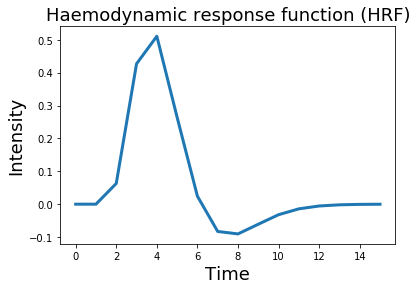

In [23]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Haemodynamic response function (HRF)', fontsize=18)

In [24]:
def plot_timeseries(data, linewidth=3, labels=None):
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        plt.legend(labels, fontsize=18)

Let's simulate data for one large region-of-interest (ROI; e.g., average timeseries of all voxels in ventral striatum)!

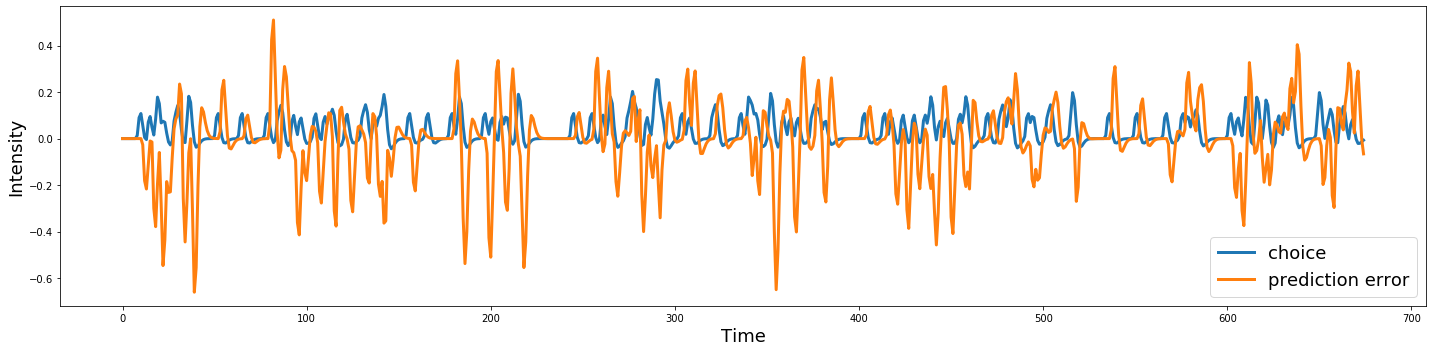

In [25]:
n_tr = 675
n_trial = 135

np.random.seed(2019)

choices = np.random.randint(10, n_tr, n_trial)
choice_trials = np.zeros(n_tr)
choice_trials[choices] = .60
choice_trials = choice_trials*np.random.rand() # add some more noise here, b/c we don't expect a main effect of choice in our ROI

PE_trials = np.zeros(n_tr)
PE_trials[choices+3] = 1*PE/np.max(PE)

roi_conv = np.vstack([np.convolve(choice_trials, hrf, mode='same'),
                        np.convolve(PE_trials, hrf, mode='same')]).T

plot_timeseries(roi_conv, labels=['choice','prediction error'])

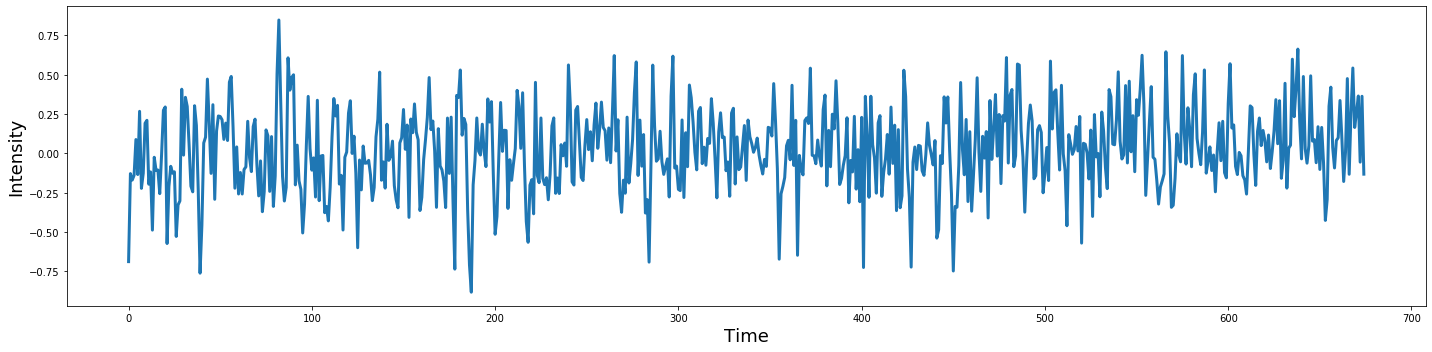

In [26]:
# add noise
epsilon = 0.15*np.random.randn(n_tr, 2)
roi_conv_noise = roi_conv + epsilon

Y = roi_conv_noise.sum(axis=1)

plot_timeseries(Y)

We can write our model out so that it is very clear what we are doing.
$$Y=β0+β1⋅Choice+β2⋅Feedback+β3⋅pmod(PE)+ϵ$$

Here, we model the effect of choice and feedback (average against implicit baseline) and we add a parametric modulator of prediction error at each trial...

In [27]:
intercept = np.ones(n_tr) # constant in OLS regression

choice_trials_est = np.zeros(n_tr)
choice_trials_est[choices] = 1  # avg effect of choice in OLS regression

prederr_trials_est = np.zeros(n_tr)
prederr_trials_est[choices] = 1 # avg effect of feedback in OLS regression

X = np.vstack([intercept, 
               np.convolve(choice_trials_est, hrf, mode='same'),
               np.convolve(prederr_trials_est, hrf, mode='same'),
               np.convolve(PE_trials, hrf, mode='same')]).T

We can also make a plot and rotate the timeseries, to better reflect the equation.

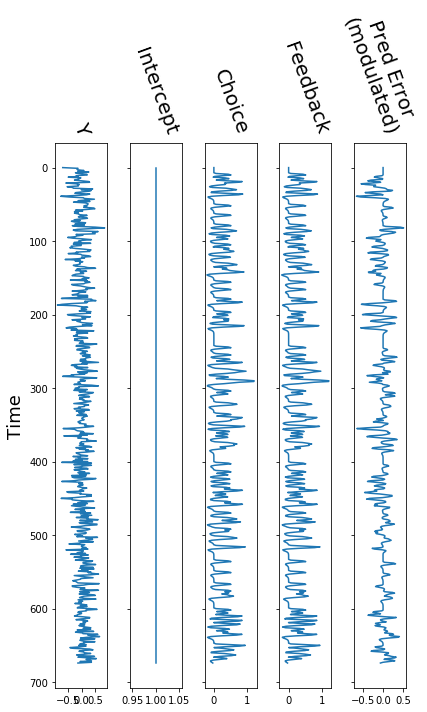

In [28]:
f, a = plt.subplots(ncols=5, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[4].plot(X[:,3], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20, rotation=290, verticalalignment='bottom', horizontalalignment='center')
a[1].set_title('Intercept', fontsize=20, rotation=290, verticalalignment='bottom')
a[2].set_title('Choice', fontsize=20, rotation=290, verticalalignment='bottom')
a[3].set_title('Feedback', fontsize=20, rotation=290, verticalalignment='bottom')
a[4].set_title('Pred Error\n(modulated)', fontsize=20, rotation=290, verticalalignment='bottom')
plt.gca().invert_yaxis()
plt.tight_layout()

We can use an Ordinary Least Squares (OLS) regression to find the $\hat{β}$ hyperplane that minimizes the error between the observed $Y$ and predicted $\hat{Y}$

GLM in linear algebra notation: $\hat{β}=(X^{T}X)^{−1}X^{T}Y$

In [29]:
beta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

Text(0.5, 1, 'Residual')

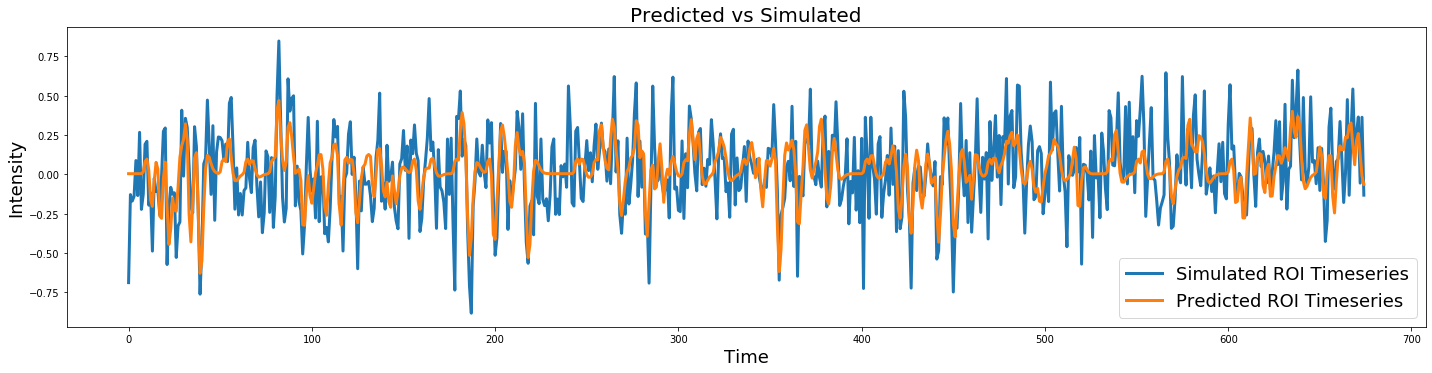

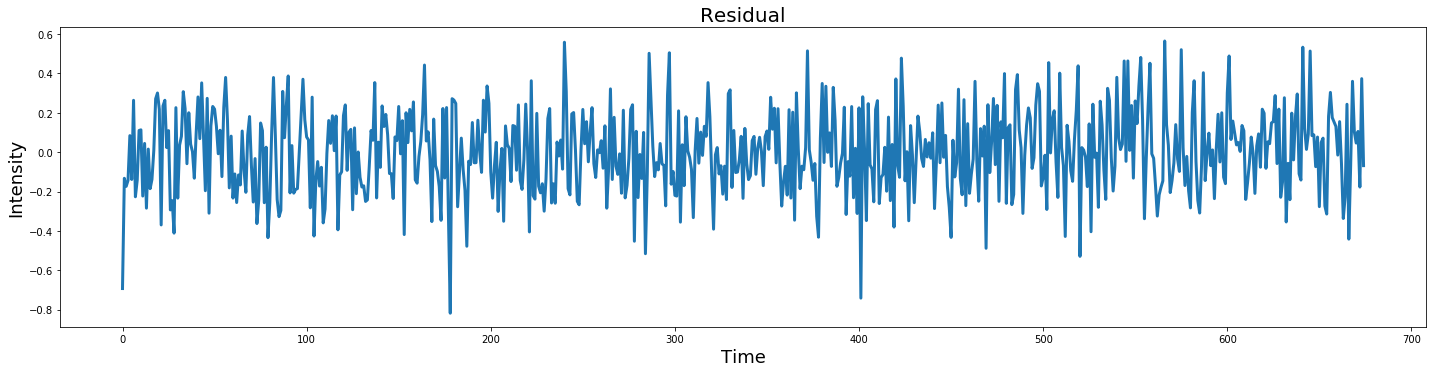

In [30]:
predicted_y = np.dot(X, beta)

predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, labels=['Simulated ROI Timeseries', 'Predicted ROI Timeseries'])
plt.title('Predicted vs Simulated', fontsize=20)

residual = Y - predicted_y
plot_timeseries(residual)
plt.title('Residual', fontsize=20)

beta PE: 0.94


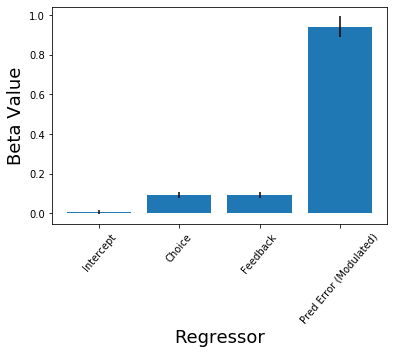

In [31]:
predicted_sigma = np.std(residual)
std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * predicted_sigma

plt.bar(['Intercept','Choice','Feedback','Pred Error (Modulated)'], beta, yerr = std_error)
plt.xticks(rotation=50)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print('beta PE: %.2f' % (beta[3]))

In [32]:
t_stat = beta / std_error
print(t_stat)

[ 0.46062316  6.08108741  6.08108741 17.80063121]


Here, we run this first-level analysis with one subject in "one ROI".

We could also run it with multiple subjects and multiple voxels/ROIs, and then conduct a one-sample t-test for group-level inference!